In [1]:
import sys
sys.path.append('../')

from Modules.Utils.Imports import *
from Modules.Models.BuildBINNs import AdaMaskBINNCovasim_arr
from Modules.Utils.ModelWrapper import ModelWrapper

import Modules.Utils.PDESolver as PDESolver
import Modules.Loaders.DataFormatter as DF
from utils import get_case_name, plot_loss_convergence

c:\Users\Teddy\anaconda3\envs\reu_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))
# helper functions
def to_torch(x):
    return torch.from_numpy(x).float().to(device)
def to_numpy(x):
    return x.detach().cpu().numpy()

Device set to cpu


In [3]:
# instantiate BINN model parameters and path
path = '../Data/covasim_data/drums_data/'
# path = '../Data/covasim_data/xin_data/'

population = int(500e3)
test_prob = 0.1
trace_prob = 0.3
keep_d = True
retrain = False
dynamic = True
masking = 3
multiple = True
parallelb = True
n_runs = 2048
chi_type = 'piecewise'

case_name = get_case_name(population, test_prob, trace_prob, keep_d, dynamic=dynamic, chi_type=chi_type)

In [4]:
if not masking==0:
    if masking==1:
        case_name = case_name + '_maskingdem'
    elif masking==2:
        case_name = case_name + '_maskinguni'
    elif masking==3:
        case_name = case_name + '_maskingnorm'

if multiple:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name + '_' + str(n_runs), plot=False)
else:
    params = DF.load_covasim_data(path, population, test_prob, trace_prob, keep_d, case_name, plot=False)

In [5]:
# split into train/val and convert to torch
# multiple==True and parallelb==False means that data is a list and not normalized
if multiple and not parallelb:
    data = np.mean(params['data'], axis=0)
    data = (data / params['population'])
    avg_masking = np.mean(params['avg_masking'], axis=0)
    avg_masking = (avg_masking / params['population'])
# multiple==True and parallelb==True means that the data is a 2d array and normalized
elif multiple and parallelb:
    data = params['data'] # parallel simulations store normalized data
    avg_masking = params['avg_masking']
# otherwise, the data is from a single simulation and is not normalized
else:
    data = params['data']
    data = (data / params['population']).to_numpy()
    avg_masking = params['avg_masking']
    avg_masking = (avg_masking / params['population'])
    
params.pop('data')

N = len(data)
t_max = N - 1
t = np.arange(N)[:,None]

tracing_array = params['tracing_array']

In [6]:
# mydir = '../models/covasim/mask/2023-07-13_23-46-11' # norm masking, 200e3 pop, dynamic piecewise, keepd, 1024 avg., 200,000 epochs, lr=1e-4
mydir = '../models/covasim/mask/2023-07-16_16-48-08' # norm masking, 500e3 pop, dynamic piecewise, keepd, 2048 avg., 800,000 epochs, lr=5e-5

In [7]:
# instantiate BINN model
tau_lb = 0.08
tau_ub = 0.12
eta_deep = True
beta_deep = True
tau_deep = False
binn = AdaMaskBINNCovasim_arr(params, 
                          t_max, 
                          tracing_array, 
                          keep_d=keep_d,
                          tau_lb=tau_lb,
                          tau_ub=tau_ub,
                          eta_deep=eta_deep,
                          beta_deep=beta_deep,
                          tau_deep=tau_deep).to(device)

parameters = binn.parameters()
model = ModelWrapper(binn, None, None, save_name=os.path.join(mydir, case_name))

In [8]:
# load model weights. if retrain==True then load the retrained model
if retrain:
    model.save_name += '_retrain'
model.save_name += '_best_val'
model.load(model.save_name + '_model', device=device)

# grab initial condition
u0 = data[0, :].copy()

In [9]:
# learned surface fitter
def surface_fitter(t):
    res = binn.surface_fitter(to_torch(t))
    return res

# learned contact_rate function
def contact_rate(u):
    res = binn.eta_mask_func(to_torch(u)) # [:,[0,3,4]]
    return to_numpy(res)

# learned effective tracing rate function
def beta(u):
    res = binn.beta_func(to_torch(u))
    return to_numpy(res)

# learned diagnosis of quarantined rate function
def tau(u):
    res = binn.tau_func(to_torch(u))
    return to_numpy(res)

In [10]:
cat_arr = np.concatenate((data[:,[0,3,4]], avg_masking[:,None]), axis=1)
eta_values = contact_rate(cat_arr)

In [11]:
# simulate PDE. First grab the parameter values from the loaded BINN model.
params['yita_lb'] = model.model.yita_lb
params['yita_ub'] = model.model.yita_ub
params['beta_lb'] = model.model.beta_lb
params['beta_ub'] = model.model.beta_ub
params['tau_lb'] = model.model.tau_lb
params['tau_ub'] = model.model.tau_ub

In [12]:
# if D is to be included in the model, otherwise use the other solver.
if keep_d:
    RHS = PDESolver.STEAYDQRF_RHS_dynamic_maskarr
    u_sim_NN = PDESolver.STEAYDQRF_sim(RHS, u0, t, contact_rate, beta, tau, params, chi_type)
    u_sim_NN *= population

c:\Users\Teddy\Documents\UG Research\DRUMS\COVASIM_EQL_BINNS\Notebooks\..\Modules\Utils\PDESolver.py:452: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([ds, dt, de, da, dy, dd, dq, dr, df])


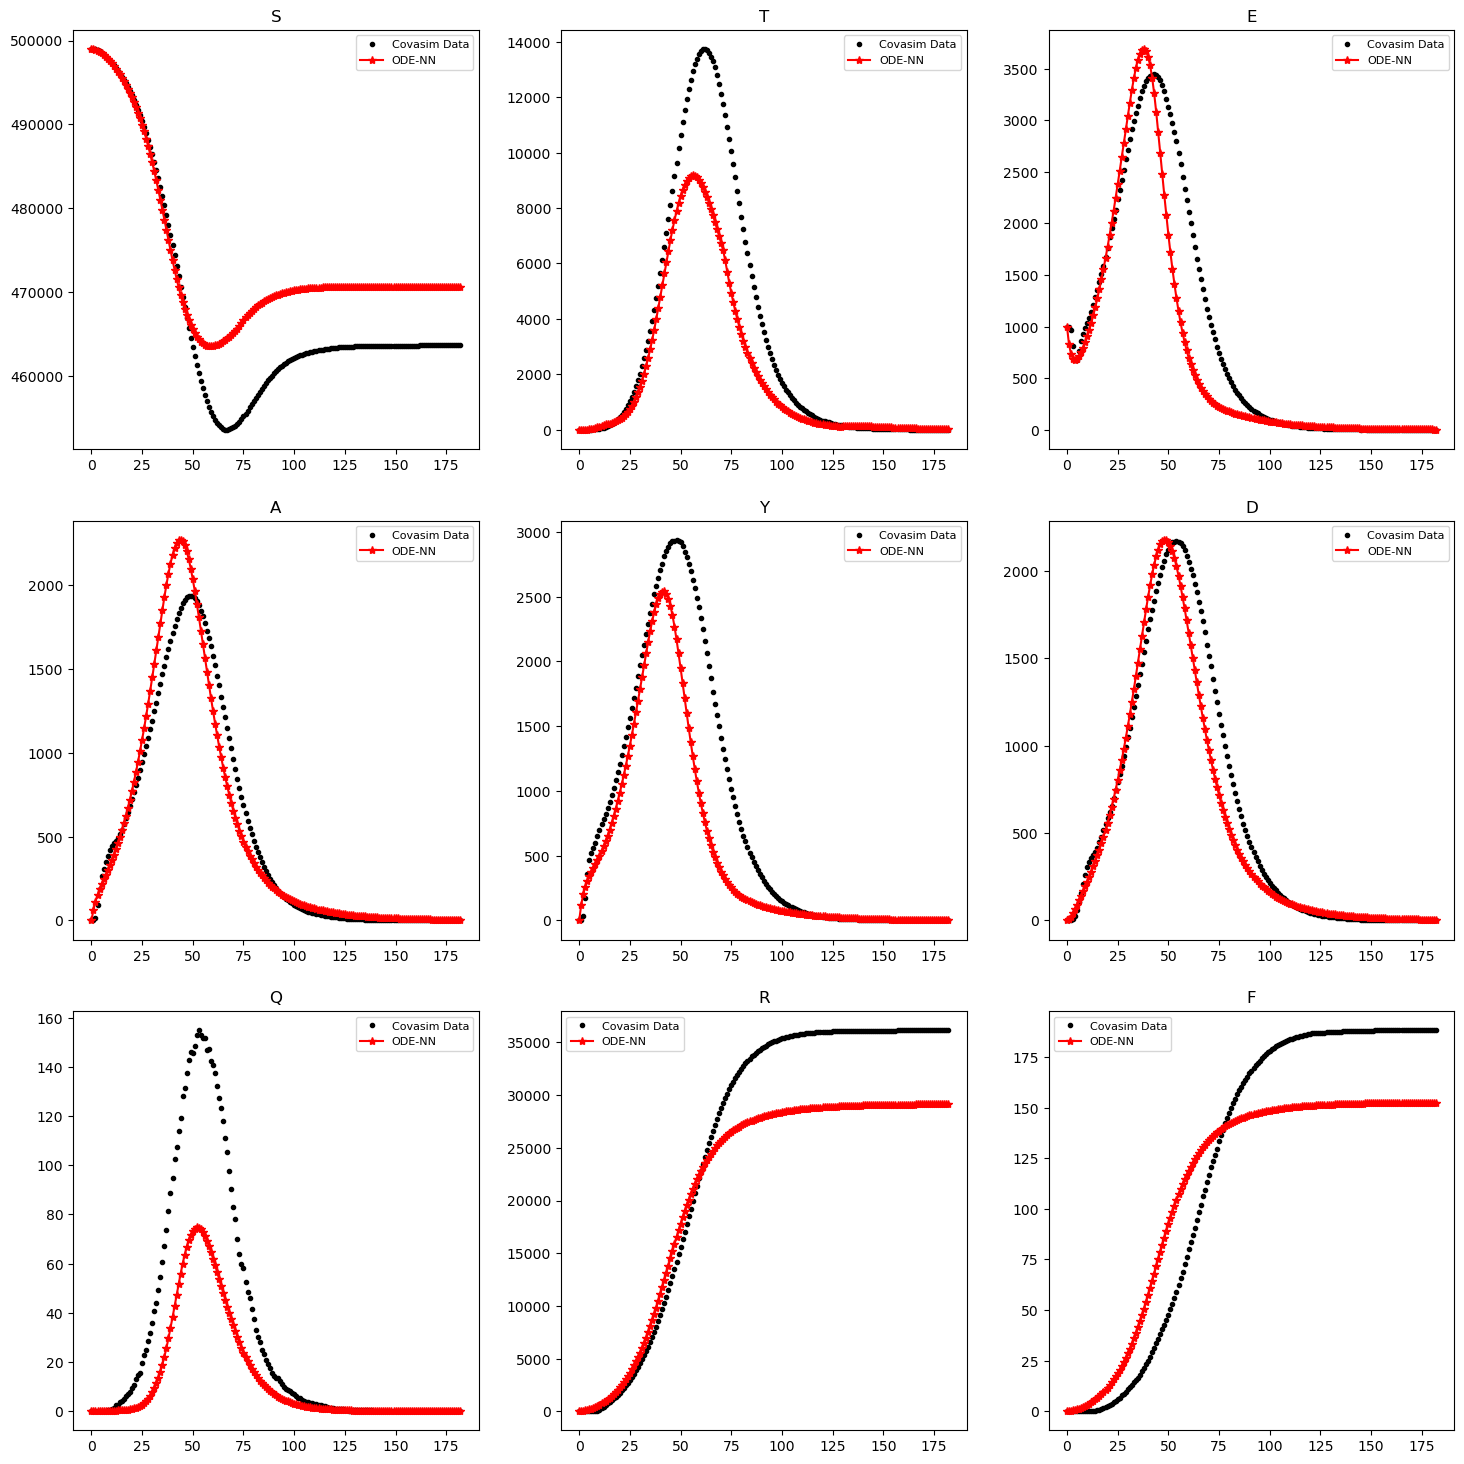

In [16]:
# rescale data values to represent number of people in state X rather than ratios
data /= population

plot=True
if plot:
    # data = params['data']
    n = data.shape[1]
    col_names = list('STEAYDQRF') if keep_d else list('STEAYQRF')
    # t = np.arange(1, data.shape[0] + 1)
    # plot compartments
    fig = plt.figure(figsize=(15, 15))
    for i in range(1, n + 1):
        ax = fig.add_subplot(int(np.ceil(n / 3)), 3, i)
        ax.plot(t, data[:, i - 1], '.k', label='Covasim Data')
        ax.plot(t, u_sim_NN[:, i - 1], '-*r', label='ODE-NN')
        ax.set_title(col_names[i - 1])
        ax.legend(fontsize=8)
        fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
        plt.tight_layout(pad=2)
        plt.savefig(os.path.join(model.save_folder, case_name + '.png') )
        # plt.show()